# CNN Emotion Detection Training
This notebook trains a CNN model for emotion detection with comprehensive evaluation metrics and visualizations.

In [28]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc
from torch.utils.data import WeightedRandomSampler
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
# Configuration
class Config:
    # Paths
    data_dir = '../data'
    train_dir = os.path.join(data_dir, 'train')
    val_dir = os.path.join(data_dir, 'val')
    models_dir = '../models'
    results_dir = '../results'
    
    # Training parameters
    batch_size = 32
    learning_rate = 0.001
    num_epochs = 100
    patience = 10  # Early stopping
    
    # Model parameters
    img_size = 224
    num_classes = 4
    
    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Model save name
    model_name = 'cnn_emotion_model_v6.pth'

config = Config()
print(f"Using device: {config.device}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
CUDA available: True
GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [ ]:
# Data transforms with augmentation
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((config.img_size, config.img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=15, translate=(0.1,0.1), shear=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.1,2.0)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((config.img_size, config.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(config.train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(config.val_dir, transform=val_transform)

# Get class names
class_names = train_dataset.classes
print(f"Classes: {class_names}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

class_counts = [len(os.listdir(os.path.join(config.train_dir, c))) for c in class_names]
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [class_weights[label] for _, label in train_dataset.samples]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, sampler=sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=4)

Classes: ['anger', 'fear', 'joy', 'sad']
Number of training samples: 20653
Number of validation samples: 5114


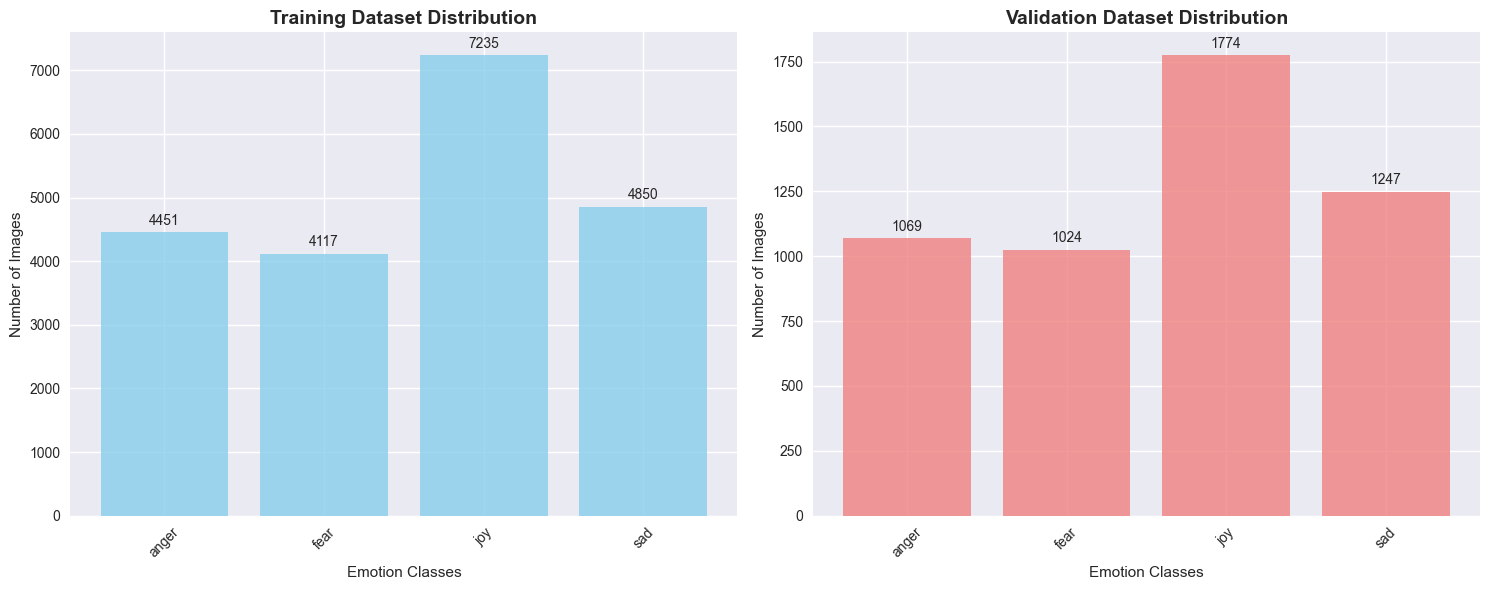

In [ ]:
# Visualize dataset distribution
def plot_dataset_distribution():
    train_counts = [len([f for f in os.listdir(os.path.join(config.train_dir, cls)) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))]) for cls in class_names]
    val_counts = [len([f for f in os.listdir(os.path.join(config.val_dir, cls)) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]) for cls in class_names]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Training distribution
    ax1.bar(class_names, train_counts, color='skyblue', alpha=0.8)
    ax1.set_title('Training Dataset Distribution', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Emotion Classes')
    ax1.set_ylabel('Number of Images')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for i, v in enumerate(train_counts):
        ax1.text(i, v + max(train_counts)*0.01, str(v), ha='center', va='bottom')
    
    # Validation distribution
    ax2.bar(class_names, val_counts, color='lightcoral', alpha=0.8)
    ax2.set_title('Validation Dataset Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Emotion Classes')
    ax2.set_ylabel('Number of Images')
    ax2.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for i, v in enumerate(val_counts):
        ax2.text(i, v + max(val_counts)*0.01, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('../results/cnn_dataset_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create visualizations directory
# os.makedirs(config.models_dir, exist_ok=True)
# os.makedirs(config.results_dir, exist_ok=True)
plot_dataset_distribution()

In [79]:
import torch.nn.functional as F

# Define CNN Model
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(EmotionCNN, self).__init__()
        
        # Use ResNet18 as backbone
        self.backbone = models.resnet18(pretrained=True)
        
        # Modify the final layer
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.backbone.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        return self.backbone(x)
    
# class FocalLoss(nn.Module):
#     def __init__(self, gamma=2.0, weight=None):
#         super().__init__()
#         self.gamma = gamma
#         self.weight = weight
#     def forward(self, logits, targets):
#         ce = F.cross_entropy(logits, targets, weight=self.weight, reduction='none')
#         pt = torch.exp(-ce)
#         loss = ((1 - pt) ** self.gamma) * ce
#         return loss.mean()    

# Initialize model
model = EmotionCNN(num_classes=config.num_classes).to(config.device)

# Freeze backbone
for p in model.backbone.parameters():
    p.requires_grad = False
# unfreeze layer
for p in model.backbone.layer2.parameters(): p.requires_grad = True
for p in model.backbone.layer3.parameters(): p.requires_grad = True
for p in model.backbone.layer4.parameters(): p.requires_grad = True

# Optimizer dan scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

head_params = list(model.backbone.fc.parameters())
l4_params   = list(model.backbone.layer4.parameters())
l3_params   = list(model.backbone.layer3.parameters())
l2_params   = list(model.backbone.layer2.parameters())

optimizer = optim.Adam([
    {'params': head_params, 'lr': 1.5e-4},
    {'params': l4_params,   'lr': 1.0e-4},
    {'params': l3_params,   'lr': 7.5e-5},
    {'params': l2_params,   'lr': 5.0e-5},
], weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")

Model initialized with 11308868 parameters


In [80]:
# Training function with comprehensive metrics
def train_model():
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    learning_rates = []
    
    best_val_acc = 0.0
    patience_counter = 0
    
    for epoch in range(config.num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(config.device), target.to(config.device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()
            
            if batch_idx % 50 == 0:
                print(f'Epoch {epoch+1}/{config.num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct_train / total_train
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(config.device), target.to(config.device)
                output = model(data)
                val_loss += criterion(output, target).item()
                _, predicted = torch.max(output.data, 1)
                total_val += target.size(0)
                correct_val += (predicted == target).sum().item()
        
        val_loss /= len(val_loader)
        val_acc = 100. * correct_val / total_val
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        learning_rates.append(current_lr)
        
        print(f'Epoch {epoch+1}/{config.num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'  Learning Rate: {current_lr:.6f}')
        print('-' * 50)
        
        # Early stopping and best model saving
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
                'class_names': class_names
            }, os.path.join(config.models_dir, config.model_name))
            print(f'New best model saved with validation accuracy: {best_val_acc:.2f}%')
        else:
            patience_counter += 1
            
        if patience_counter >= config.patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'learning_rates': learning_rates,
        'best_val_acc': best_val_acc
    }

# Create checkpoint directory
os.makedirs(config.checkpoint_dir, exist_ok=True)

# Start training
print("Starting training...")
training_history = train_model()

Starting training...
Epoch 1/100, Batch 0/646, Loss: 1.4148
Epoch 1/100, Batch 50/646, Loss: 1.3706
Epoch 1/100, Batch 100/646, Loss: 1.1937
Epoch 1/100, Batch 150/646, Loss: 1.0736
Epoch 1/100, Batch 200/646, Loss: 1.2126
Epoch 1/100, Batch 250/646, Loss: 0.8574
Epoch 1/100, Batch 300/646, Loss: 1.0313
Epoch 1/100, Batch 350/646, Loss: 0.7682
Epoch 1/100, Batch 400/646, Loss: 0.9335
Epoch 1/100, Batch 450/646, Loss: 0.8719
Epoch 1/100, Batch 500/646, Loss: 1.0281
Epoch 1/100, Batch 550/646, Loss: 1.1048
Epoch 1/100, Batch 600/646, Loss: 0.8700
Epoch 1/100:
  Train Loss: 1.0633, Train Acc: 55.30%
  Val Loss: 0.8788, Val Acc: 65.70%
  Learning Rate: 0.000150
--------------------------------------------------
New best model saved with validation accuracy: 65.70%
Epoch 2/100, Batch 0/646, Loss: 0.8206
Epoch 2/100, Batch 50/646, Loss: 0.8633
Epoch 2/100, Batch 100/646, Loss: 0.7535
Epoch 2/100, Batch 150/646, Loss: 1.0394
Epoch 2/100, Batch 200/646, Loss: 0.9458
Epoch 2/100, Batch 250/646,

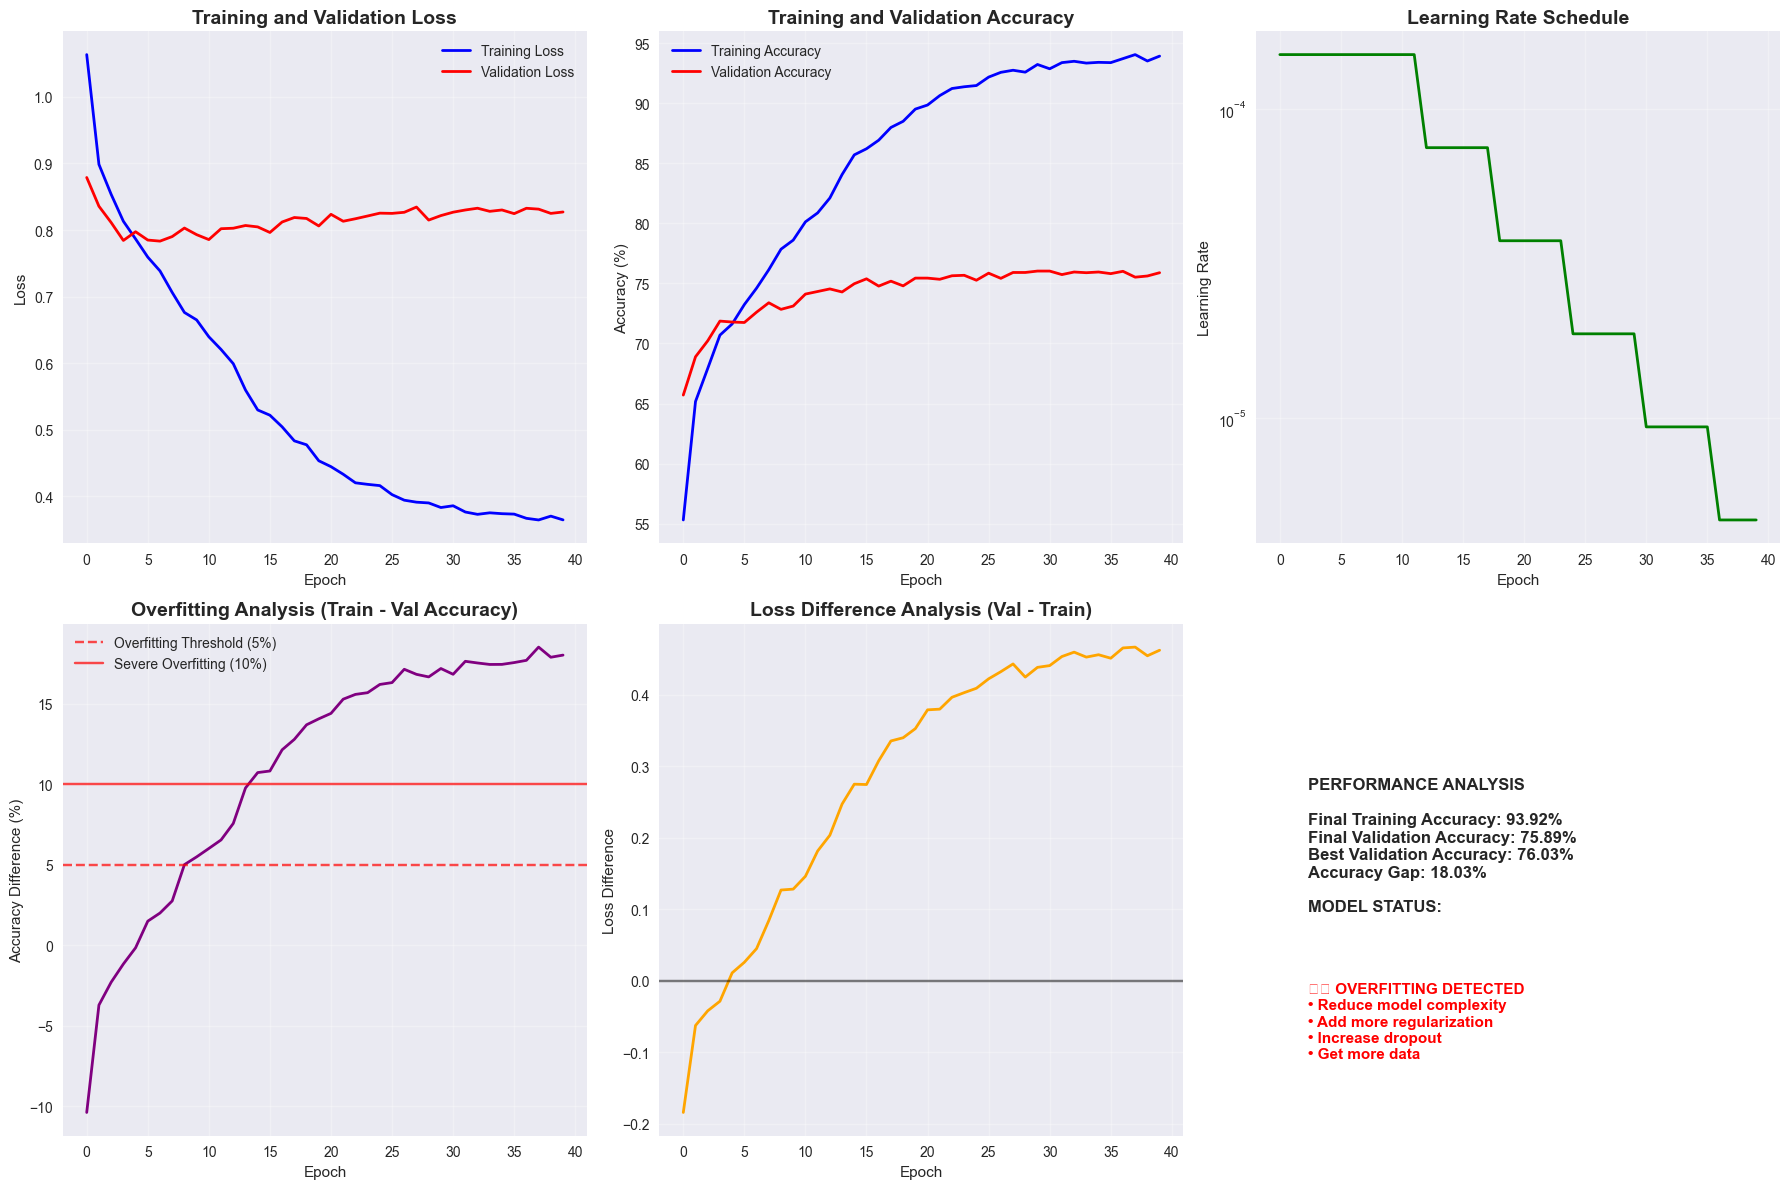

In [81]:
# Comprehensive visualization function
def plot_training_results(history):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Loss curves
    axes[0, 0].plot(history['train_losses'], label='Training Loss', color='blue', linewidth=2)
    axes[0, 0].plot(history['val_losses'], label='Validation Loss', color='red', linewidth=2)
    axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy curves
    axes[0, 1].plot(history['train_accuracies'], label='Training Accuracy', color='blue', linewidth=2)
    axes[0, 1].plot(history['val_accuracies'], label='Validation Accuracy', color='red', linewidth=2)
    axes[0, 1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Learning rate
    axes[0, 2].plot(history['learning_rates'], color='green', linewidth=2)
    axes[0, 2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Learning Rate')
    axes[0, 2].set_yscale('log')
    axes[0, 2].grid(True, alpha=0.3)
    
    # Overfitting analysis
    train_val_diff = np.array(history['train_accuracies']) - np.array(history['val_accuracies'])
    axes[1, 0].plot(train_val_diff, color='purple', linewidth=2)
    axes[1, 0].axhline(y=5, color='red', linestyle='--', alpha=0.7, label='Overfitting Threshold (5%)')
    axes[1, 0].axhline(y=10, color='red', linestyle='-', alpha=0.7, label='Severe Overfitting (10%)')
    axes[1, 0].set_title('Overfitting Analysis (Train - Val Accuracy)', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy Difference (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Loss difference analysis
    loss_diff = np.array(history['val_losses']) - np.array(history['train_losses'])
    axes[1, 1].plot(loss_diff, color='orange', linewidth=2)
    axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[1, 1].set_title('Loss Difference Analysis (Val - Train)', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss Difference')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Performance summary
    axes[1, 2].axis('off')
    
    # Analysis text
    final_train_acc = history['train_accuracies'][-1]
    final_val_acc = history['val_accuracies'][-1]
    best_val_acc = max(history['val_accuracies'])
    final_diff = final_train_acc - final_val_acc
    
    analysis_text = f"""PERFORMANCE ANALYSIS
    
Final Training Accuracy: {final_train_acc:.2f}%
Final Validation Accuracy: {final_val_acc:.2f}%
Best Validation Accuracy: {best_val_acc:.2f}%
Accuracy Gap: {final_diff:.2f}%

MODEL STATUS:
"""
    
    if final_diff > 10:
        status = "⚠️ OVERFITTING DETECTED\n• Reduce model complexity\n• Add more regularization\n• Increase dropout\n• Get more data"
        color = 'red'
    elif final_diff > 5:
        status = "⚡ MILD OVERFITTING\n• Monitor closely\n• Consider early stopping\n• Tune regularization"
        color = 'orange'
    elif final_val_acc < 60:
        status = "📈 UNDERFITTING\n• Increase model complexity\n• Reduce regularization\n• Train longer\n• Check data quality"
        color = 'blue'
    else:
        status = "✅ GOOD PERFORMANCE\n• Model is well-balanced\n• Consider fine-tuning\n• Ready for deployment"
        color = 'green'
    
    axes[1, 2].text(0.1, 0.7, analysis_text, fontsize=12, fontweight='bold', 
                   verticalalignment='top', transform=axes[1, 2].transAxes)
    axes[1, 2].text(0.1, 0.3, status, fontsize=11, color=color, fontweight='bold',
                   verticalalignment='top', transform=axes[1, 2].transAxes)
    
    plt.tight_layout()
    plt.savefig('../results/cnn_training_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot training results
plot_training_results(training_history)

In [82]:
# Detailed evaluation on test set
def evaluate_model():
    # Load best model
    checkpoint = torch.load(os.path.join(config.models_dir, config.model_name))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(config.device), target.to(config.device)
            output = model(data)
            probs = torch.softmax(output, dim=1)
            _, predicted = torch.max(output, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

# Get predictions
predictions, true_labels, probabilities = evaluate_model()

# Calculate metrics
accuracy = (predictions == true_labels).mean() * 100
f1 = f1_score(true_labels, predictions, average='weighted') * 100
precision = precision_score(true_labels, predictions, average='weighted') * 100
recall = recall_score(true_labels, predictions, average='weighted') * 100

print(f"\nFinal Model Performance:")
print(f"Accuracy: {accuracy:.2f}%")
print(f"F1-Score: {f1:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")


Final Model Performance:
Accuracy: 76.03%
F1-Score: 75.97%
Precision: 76.01%
Recall: 76.03%


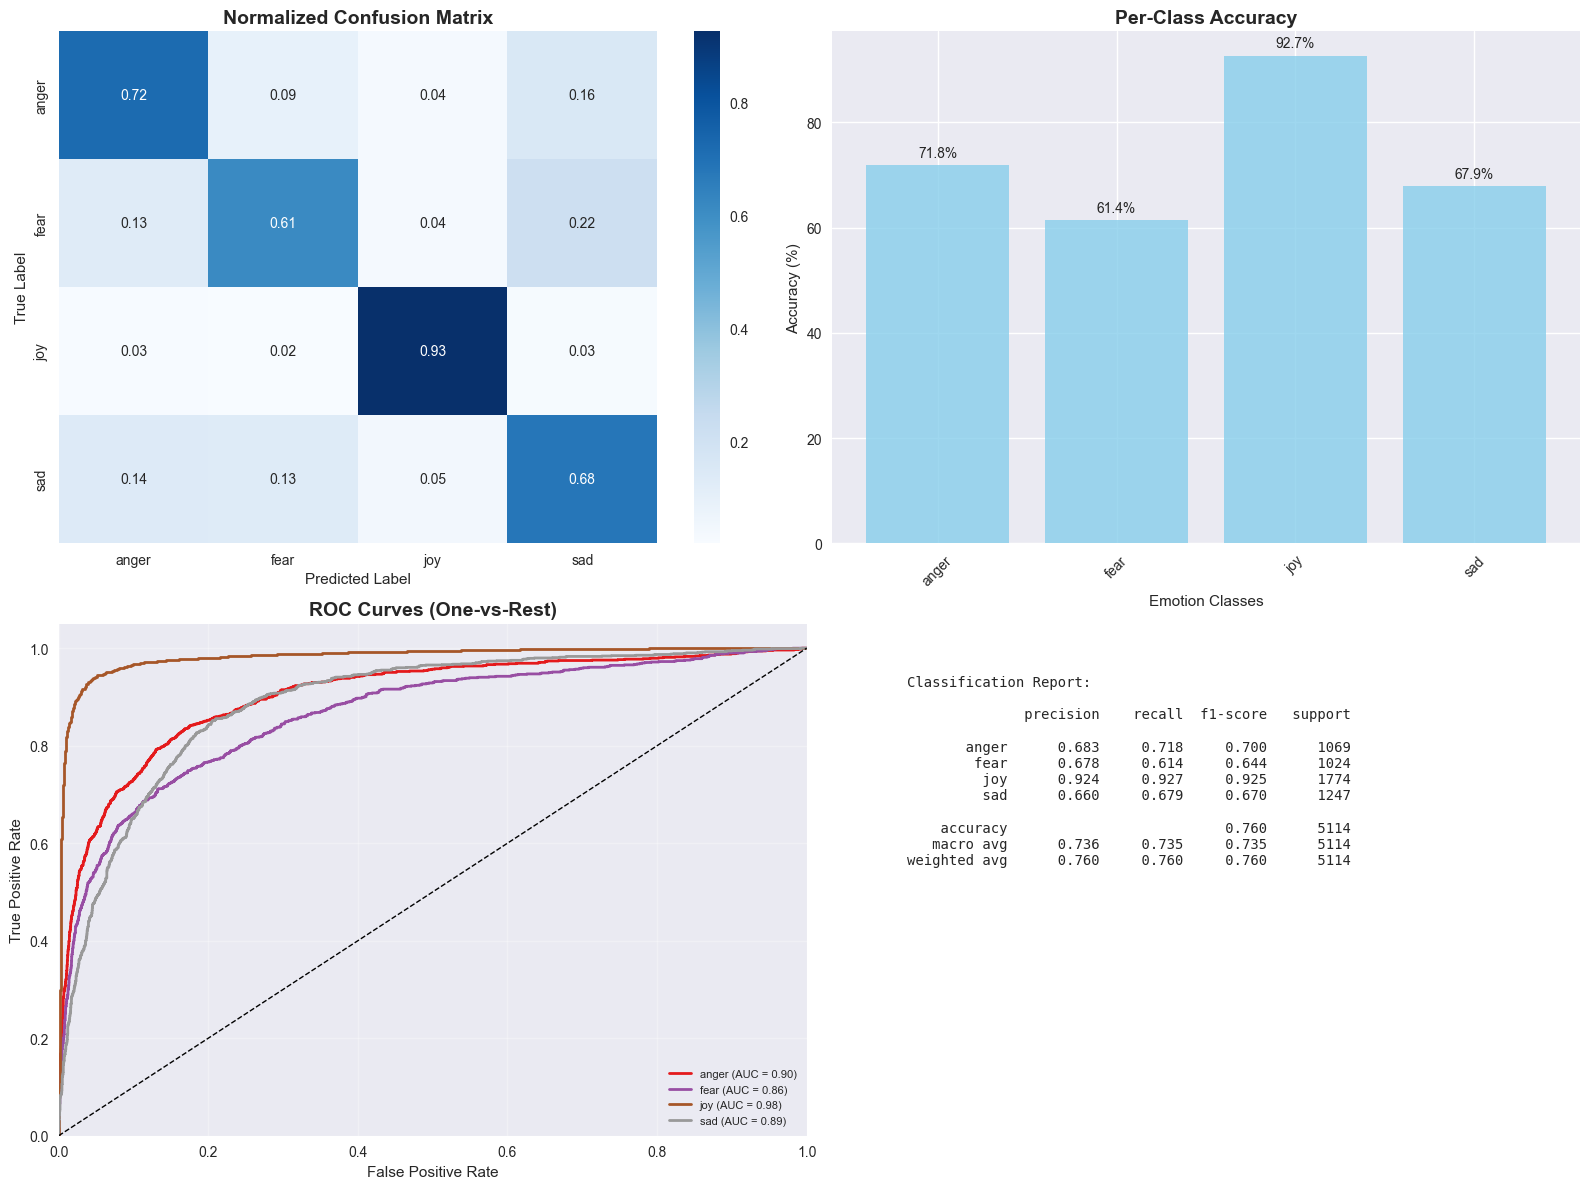

In [83]:
# Confusion Matrix and Classification Report
def plot_evaluation_metrics(y_true, y_pred, y_probs, class_names):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=axes[0, 0])
    axes[0, 0].set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Predicted Label')
    axes[0, 0].set_ylabel('True Label')
    
    # Per-class accuracy
    class_accuracies = cm.diagonal() / cm.sum(axis=1) * 100
    bars = axes[0, 1].bar(class_names, class_accuracies, color='skyblue', alpha=0.8)
    axes[0, 1].set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Emotion Classes')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, acc in zip(bars, class_accuracies):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                       f'{acc:.1f}%', ha='center', va='bottom')
    
    # ROC Curves (One-vs-Rest)
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
    
    colors = plt.cm.Set1(np.linspace(0, 1, len(class_names)))
    for i, (class_name, color) in enumerate(zip(class_names, colors)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        axes[1, 0].plot(fpr, tpr, color=color, linewidth=2,
                       label=f'{class_name} (AUC = {roc_auc:.2f})')
    
    axes[1, 0].plot([0, 1], [0, 1], 'k--', linewidth=1)
    axes[1, 0].set_xlim([0.0, 1.0])
    axes[1, 0].set_ylim([0.0, 1.05])
    axes[1, 0].set_xlabel('False Positive Rate')
    axes[1, 0].set_ylabel('True Positive Rate')
    axes[1, 0].set_title('ROC Curves (One-vs-Rest)', fontsize=14, fontweight='bold')
    axes[1, 0].legend(loc="lower right", fontsize=8)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Classification Report as text
    axes[1, 1].axis('off')
    report = classification_report(y_true, y_pred, target_names=class_names, digits=3)
    axes[1, 1].text(0.1, 0.9, 'Classification Report:\n\n' + report, 
                   fontsize=10, fontfamily='monospace',
                   verticalalignment='top', transform=axes[1, 1].transAxes)
    
    plt.tight_layout()
    plt.savefig('../results/cnn_evaluation_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot evaluation metrics
plot_evaluation_metrics(true_labels, predictions, probabilities, class_names)

## Testing (bahan deployment)

In [ ]:
# =========================================================
# Inference + Folder Eval + Diagnostic Checklist (1 file)
# =========================================================
import os, time
from pathlib import Path
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageFilter
import pandas as pd
import cv2

# -----------------------------
# 0) KONFIGURASI
# -----------------------------
CHECKPOINT_PATH = r"E:\Folder Kuliah\Semester 7\CCI\Github Repository\emotion-detection\models\cnn_emotion_model_v6.pth"
PATH_GAMBAR    = r"E:\Folder Kuliah\Semester 7\CCI\Github Repository\emotion-detection\images\test\anger_WIN_20251009_00_23_48_Pro.jpg"
FOLDER_PATH    = r"E:\Folder Kuliah\Semester 7\CCI\Github Repository\emotion-detection\images\test"
OUT_DIR        = r"E:\Folder Kuliah\Semester 7\CCI\Github Repository\emotion-detection\results"

# Jika di notebook kamu sudah ada `config`, variabel di bawah otomatis baca dari situ.
IMG_SIZE = getattr(globals().get('config', object()), 'img_size', 224)
MEAN     = getattr(globals().get('config', object()), 'mean', [0.485, 0.456, 0.406])
STD      = getattr(globals().get('config', object()), 'std',  [0.229, 0.224, 0.225])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -----------------------------
# 1) MODEL (identik dengan training)
# -----------------------------
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.backbone.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.backbone(x)

# -----------------------------
# 2) LOAD CHECKPOINT + TRANSFORM
# -----------------------------
def load_checkpoint(path):
    ckpt = torch.load(path, map_location=device)
    # dukung beberapa kemungkinan kunci:
    state_keys = ['model_state_dict', 'state_dict', 'ema_state_dict', 'model']
    state_dict = None
    for k in state_keys:
        if k in ckpt:
            obj = ckpt[k]
            state_dict = obj.state_dict() if hasattr(obj, 'state_dict') else obj
            break
    if state_dict is None and all(isinstance(v, torch.Tensor) for v in ckpt.values()):
        state_dict = ckpt  # pure state_dict

    class_names = ckpt.get('class_names', ['anger', 'fear', 'joy', 'sad'])
    model = EmotionCNN(num_classes=len(class_names)).to(device)
    if state_dict is None:
        raise RuntimeError("Tidak menemukan state_dict dalam checkpoint. Pastikan kuncinya 'model_state_dict' atau serupa.")
    model.load_state_dict(state_dict, strict=True)
    model.eval()
    return model, class_names

# Transform VAL **persis** seperti training: Resize -> ToTensor -> Normalize (tanpa center-crop)
val_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

# Varian lain untuk diagnosa
val_tf_center = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.14)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])
val_tf_no_norm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

def detect_and_crop_face(path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if len(faces) == 0:
        return Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    (x, y, w, h) = faces[0]
    margin_x = int(0.15 * w)          # sebelumnya 0.2 * w (horisontal bisa lebih kecil)
    margin_top = int(0.10 * h)        # atas sedikit saja
    margin_bot = int(0.35 * h)        # ✅ bawah diperbesar (mulut/dagu masuk)

    x1 = max(0, x - margin_x)
    y1 = max(0, y - margin_top)
    x2 = min(img.shape[1], x + w + margin_x)
    y2 = min(img.shape[0], y + h + margin_bot)
    face_crop = img[y1:y2, x1:x2]
    
    return Image.fromarray(cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB))

# -----------------------------
# 3) PREDIKSI SATU GAMBAR
# -----------------------------
def preprocess_image(path):
    img = detect_and_crop_face(path)          # PIL RGB

    # === CLAHE: samakan kontras dgn dataset ===
    g = np.array(img.convert("L"))            # ke grayscale (array 2D)
    clahe = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(8,8))
    g = clahe.apply(g)                        # equalize lokal
    img = Image.fromarray(g).convert("RGB")   # balik ke 3-channel RGB

    return val_tf(img).unsqueeze(0).to(device)


@torch.inference_mode()
def predict_emotion(model, x_tensor, class_names):
    logits = model(x_tensor)
    probs = F.softmax(logits, dim=1)[0]
    conf, idx = probs.max(dim=0)
    return {
        'emotion': class_names[idx.item()],
        'confidence': float(conf.item()),
        'all_probs': {class_names[i]: float(probs[i].item()) for i in range(len(class_names))},
        'entropy': float(-torch.sum(probs * torch.log(probs + 1e-12)).item())
    }

# TTA ringan (flip horizontal + resize-center)
@torch.inference_mode()
def predict_tta(model, img_pil, class_names):
    tfs = [
        val_tf,
        lambda im: val_tf(im.transpose(Image.FLIP_LEFT_RIGHT))
    ]
    # acc = 0
    # for tf in tfs:
    #     x = (tf(img_pil) if callable(tf) else tf(im)).unsqueeze(0).to(device) if False else None
    # implement properly
    probs_sum = None
    for tf in tfs:
        x = (tf(img_pil) if not callable(tf) else tf(img_pil)).unsqueeze(0).to(device)
        p = F.softmax(model(x), dim=1)
        probs_sum = p if probs_sum is None else probs_sum + p
    probs = (probs_sum / len(tfs))[0]
    conf, idx = probs.max(dim=0)
    return class_names[idx.item()], float(conf.item())

# -----------------------------
# 4) FOLDER: EVALUASI / PREDIKSI
# -----------------------------
class FlatFolder(Dataset):
    exts = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")
    def __init__(self, root, tf):
        self.paths = [str(p) for p in Path(root).glob("*") if p.suffix.lower() in self.exts]
        self.tf = tf
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        p = self.paths[i]
        try:
            img = Image.open(p).convert("RGB")
            return self.tf(img), p
        except Exception as e:
            print(f"⚠️ Skip file error: {p} ({e})")
            dummy = torch.zeros(3, IMG_SIZE, IMG_SIZE)
            return dummy, p

def is_imagefolder_like(root):
    rootp = Path(root)
    subs = [d for d in rootp.iterdir() if d.is_dir()]
    if len(subs) < 2: return False
    exts = FlatFolder.exts
    return any(any(p.suffix.lower() in exts for p in d.glob("*")) for d in subs)

@torch.inference_mode()
def run_folder(model, class_names, folder_path, batch_size=32, num_workers=2, save_csv=True):
    folder_path = Path(folder_path)
    ts = time.strftime("%Y%m%d-%H%M%S")
    out_dir = Path(OUT_DIR); out_dir.mkdir(parents=True, exist_ok=True)
    if is_imagefolder_like(folder_path):
        ds = datasets.ImageFolder(str(folder_path), transform=val_tf)
        dl = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        y_true, y_pred, confs = [], [], []
        for x, y in dl:
            x = x.to(device)
            probs = F.softmax(model(x), dim=1)
            conf, pred = probs.max(dim=1)
            y_true += y.cpu().tolist()
            y_pred += pred.cpu().tolist()
            confs  += conf.cpu().tolist()
        names = ds.classes  # pakai label dari folder
        acc = (np.array(y_true) == np.array(y_pred)).mean()
        print(f"[EVAL] Accuracy: {acc*100:.2f}%  N={len(y_true)}")
        # distribusi prediksi:
        counts = {names[i]: int(np.sum(np.array(y_pred)==i)) for i in range(len(names))}
        print("[EVAL] Pred distribusi:", counts)
        if save_csv:
            df = pd.DataFrame({
                "path": [s[0] for s in ds.samples],
                "true": [names[i] for i in y_true],
                "pred": [names[i] for i in y_pred],
                "confidence": confs
            })
            csv_path = out_dir / f"eval_{folder_path.name}_{ts}.csv"
            df.to_csv(csv_path, index=False)
            print(f"[EVAL] CSV: {csv_path}")
        return {"mode":"eval","accuracy":float(acc),"counts":counts}
    else:
        ds = FlatFolder(folder_path, val_tf)
        if len(ds)==0:
            print("Folder tidak berisi gambar yang dikenali.")
            return {"mode":"predict","num_samples":0}
        dl = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=0)
        rows = []
        preds_idx = []
        for x, paths in dl:
            x = x.to(device)
            probs = F.softmax(model(x), dim=1)
            conf, pred = probs.max(dim=1)
            for pth, pi, cf in zip(paths, pred.cpu().tolist(), conf.cpu().tolist()):
                rows.append({
                    "path": pth,
                    "pred_idx": int(pi),
                    "pred_label": class_names[pi] if class_names else str(pi),
                    "confidence": float(cf),
                })
                preds_idx.append(int(pi))
        # distribusi pred
        unique, cnts = np.unique(preds_idx, return_counts=True)
        distrib = {class_names[i]: int(c) for i,c in zip(unique, cnts)}
        print("[PREDICT] Distribusi prediksi:", distrib)
        if save_csv:
            csv_path = Path(OUT_DIR) / f"pred_{folder_path.name}_{ts}.csv"
            pd.DataFrame(rows).to_csv(csv_path, index=False)
            print(f"[PREDICT] CSV: {csv_path}")
        return {"mode":"predict","num_samples":len(rows), "counts":distrib}

# -----------------------------
# 5) CHECKLIST DIAGNOSTIK
# -----------------------------
def diagnostic_checklist(model, class_names, image_path):
    print("\n=== DIAGNOSTIC CHECKLIST ===")
    img = Image.open(image_path).convert("RGB")

    # a) pipeline VAL (seharusnya benar)
    x_val = val_tf(img).unsqueeze(0).to(device)
    r_val = predict_emotion(model, x_val, class_names)
    print(f"[VAL]       -> {r_val['emotion']:<6}  conf={r_val['confidence']:.3f}  entropy={r_val['entropy']:.3f}")

    # b) center-crop variant (kalau training tidak pakai ini, beda hasil = tanda mismatch)
    x_cc  = val_tf_center(img).unsqueeze(0).to(device)
    r_cc  = predict_emotion(model, x_cc, class_names)
    print(f"[CenterCrop]-> {r_cc['emotion']:<6}  conf={r_cc['confidence']:.3f}  entropy={r_cc['entropy']:.3f}")

    # c) tanpa normalisasi (jika hasilnya berubah drastis, normalisasi saat inference sudah benar)
    x_nn  = val_tf_no_norm(img).unsqueeze(0).to(device)
    with torch.inference_mode():
        logits = model(x_nn)
        probs = F.softmax(logits, dim=1)[0]
        conf, idx = probs.max(dim=0)
        entropy = float(-torch.sum(probs * torch.log(probs + 1e-12)).item())
    print(f"[No-Norm]   -> {class_names[idx.item()]:<6}  conf={float(conf.item()):.3f}  entropy={entropy:.3f}")

    # d) flip horizontal (robustness pose)
    r_flip = predict_emotion(model, val_tf(img.transpose(Image.FLIP_LEFT_RIGHT)).unsqueeze(0).to(device), class_names)
    print(f"[Flip]      -> {r_flip['emotion']:<6}  conf={r_flip['confidence']:.3f}")

    # e) blur ringan (robustness kualitas)
    r_blur = predict_emotion(model, val_tf(img.filter(ImageFilter.GaussianBlur(radius=1))).unsqueeze(0).to(device), class_names)
    print(f"[Blur]      -> {r_blur['emotion']:<6}  conf={r_blur['confidence']:.3f}")

    # f) TTA (average)
    lbl_tta, conf_tta = predict_tta(model, img, class_names)
    print(f"[TTA avg]   -> {lbl_tta:<6}  conf={conf_tta:.3f}")

    # g) probabilitas lengkap (cek bias ke satu kelas)
    print("[Probs VAL] :", {k: round(v,3) for k,v in r_val['all_probs'].items()})

# -----------------------------
# 6) RUN
# -----------------------------
if __name__ == "__main__":
    os.makedirs(OUT_DIR, exist_ok=True)
    model, class_names = load_checkpoint(CHECKPOINT_PATH)

    print("== Single image prediction ==")
    x = preprocess_image(PATH_GAMBAR)
    res = predict_emotion(model, x, class_names)
    print(res)

    # Diagnostic checklist
    diagnostic_checklist(model, class_names, PATH_GAMBAR)

    print("\n== Folder inference/evaluation ==")
    run_folder(model, class_names, FOLDER_PATH, batch_size=16, num_workers=0, save_csv=True)


== Single image prediction ==
{'emotion': 'anger', 'confidence': 0.87709641456604, 'all_probs': {'anger': 0.87709641456604, 'fear': 0.06483226269483566, 'joy': 0.03126482665538788, 'sad': 0.026806430891156197}, 'entropy': 0.497755229473114}

=== DIAGNOSTIC CHECKLIST ===
[VAL]       -> anger   conf=0.838  entropy=0.607
[CenterCrop]-> fear    conf=0.635  entropy=1.023
[No-Norm]   -> anger   conf=0.505  entropy=1.227
[Flip]      -> anger   conf=0.902
[Blur]      -> anger   conf=0.848
[TTA avg]   -> anger   conf=0.639
[Probs VAL] : {'anger': 0.838, 'fear': 0.087, 'joy': 0.043, 'sad': 0.033}

== Folder inference/evaluation ==
[PREDICT] Distribusi prediksi: {'anger': 2, 'fear': 2}
[PREDICT] CSV: E:\Folder Kuliah\Semester 7\CCI\Github Repository\emotion-detection\results\pred_test_20251010-234518.csv


## Fine Tuning

In [ ]:
# Configuration
class Config:
    # Paths
    data_dir = '../data'
    train_dir = os.path.join(data_dir, 'train')
    val_dir = os.path.join(data_dir, 'val')
    models_dir = '../models'
    models_dir_fine_tune = '../models/fine-tune'
    results_dir = '../results/fine-tune'
    
    # Training parameters
    batch_size = 32
    learning_rate = 0.001
    num_epochs = 30
    patience = 10
    
    # Model parameters
    img_size = 224
    num_classes = 4
    
     # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Model save name
    model_name = 'cnn_emotion_model_v6.pth'
    model_name_fine_tune = 'cnn_emotion_model_v6-2.pth'

config = Config()
print(f"Using device: {config.device}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
CUDA available: True
GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [14]:
# Data transforms with augmentation
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((config.img_size, config.img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=15, translate=(0.1,0.1), shear=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.1,2.0)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((config.img_size, config.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(config.train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(config.val_dir, transform=val_transform)

# Get class names
class_names = train_dataset.classes
print(f"Classes: {class_names}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

class_counts = [len(os.listdir(os.path.join(config.train_dir, c))) for c in class_names]
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [class_weights[label] for _, label in train_dataset.samples]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, sampler=sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=4)

Classes: ['anger', 'fear', 'joy', 'sad']
Number of training samples: 20693
Number of validation samples: 5114


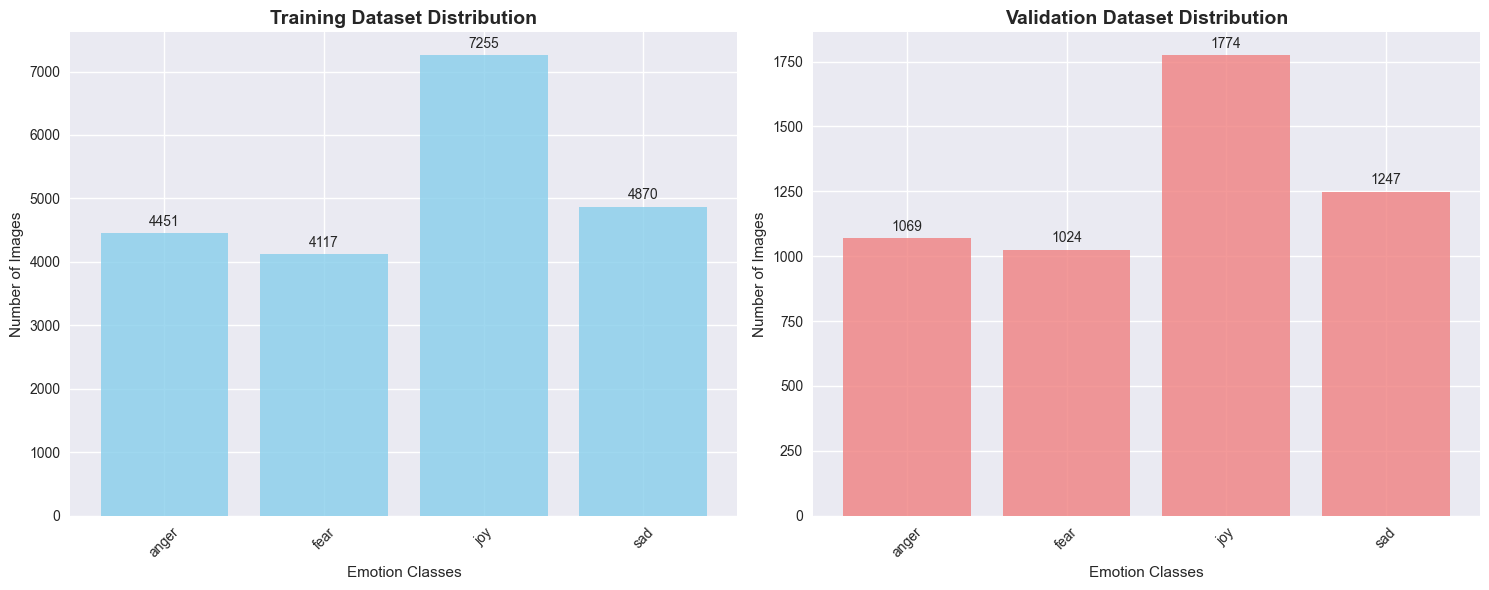

In [15]:
# Visualize dataset distribution
def plot_dataset_distribution():
    train_counts = [len([f for f in os.listdir(os.path.join(config.train_dir, cls)) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))]) for cls in class_names]
    val_counts = [len([f for f in os.listdir(os.path.join(config.val_dir, cls)) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]) for cls in class_names]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Training distribution
    ax1.bar(class_names, train_counts, color='skyblue', alpha=0.8)
    ax1.set_title('Training Dataset Distribution', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Emotion Classes')
    ax1.set_ylabel('Number of Images')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for i, v in enumerate(train_counts):
        ax1.text(i, v + max(train_counts)*0.01, str(v), ha='center', va='bottom')
    
    # Validation distribution
    ax2.bar(class_names, val_counts, color='lightcoral', alpha=0.8)
    ax2.set_title('Validation Dataset Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Emotion Classes')
    ax2.set_ylabel('Number of Images')
    ax2.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for i, v in enumerate(val_counts):
        ax2.text(i, v + max(val_counts)*0.01, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('../results/cnn_dataset_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create visualizations directory
# os.makedirs(config.models_dir_fine-tune, exist_ok=True)
# os.makedirs(config.results_dir, exist_ok=True)
plot_dataset_distribution()

In [20]:
# Define CNN Model
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(EmotionCNN, self).__init__()
        
        # Use ResNet18 as backbone
        self.backbone = models.resnet18(pretrained=True)
        
        # Modify the final layer
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.backbone.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        return self.backbone(x)

# Initialize model
model = EmotionCNN(num_classes=config.num_classes).to(config.device)

# Load before model
ckpt_path = os.path.join(config.models_dir, config.model_name)
ckpt = torch.load(ckpt_path, map_location=config.device)
model.load_state_dict(ckpt['model_state_dict'])
print(f"Loaded weights from {ckpt_path}")

# Freeze backbone
for p in model.backbone.parameters():
    p.requires_grad = False
# unfreeze layer
for p in model.backbone.layer4.parameters(): p.requires_grad = True

# Optimizer dan scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

head_params = list(model.backbone.fc.parameters())
l4_params   = list(model.backbone.layer4.parameters())

optimizer = optim.Adam([
    {'params': head_params, 'lr': 1.5e-4},
    {'params': l4_params,   'lr': 1.e-4},
], weight_decay=2e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")

Loaded weights from ../models\cnn_emotion_model_v6.pth
Model initialized with 11308868 parameters


In [21]:
# Training function with comprehensive metrics
def train_model():
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    learning_rates = []
    
    best_val_acc = 0.0
    patience_counter = 0
    
    for epoch in range(config.num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(config.device), target.to(config.device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()
            
            if batch_idx % 50 == 0:
                print(f'Epoch {epoch+1}/{config.num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct_train / total_train
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(config.device), target.to(config.device)
                output = model(data)
                val_loss += criterion(output, target).item()
                _, predicted = torch.max(output.data, 1)
                total_val += target.size(0)
                correct_val += (predicted == target).sum().item()
        
        val_loss /= len(val_loader)
        val_acc = 100. * correct_val / total_val
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        learning_rates.append(current_lr)
        
        print(f'Epoch {epoch+1}/{config.num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'  Learning Rate: {current_lr:.6f}')
        print('-' * 50)
        
        # Early stopping and best model saving
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
                'class_names': class_names
            }, os.path.join(config.models_dir_fine_tune, config.model_name_fine_tune))
            print(f'New best fine-tune model saved with validation accuracy: {best_val_acc:.2f}%')
        else:
            patience_counter += 1
            
        if patience_counter >= config.patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'learning_rates': learning_rates,
        'best_val_acc': best_val_acc
    }

# Start training
print("Starting training...")
training_history = train_model()

Starting training...
Epoch 1/15, Batch 0/647, Loss: 0.3014
Epoch 1/15, Batch 50/647, Loss: 0.5867
Epoch 1/15, Batch 100/647, Loss: 0.3214
Epoch 1/15, Batch 150/647, Loss: 0.4557
Epoch 1/15, Batch 200/647, Loss: 0.3859
Epoch 1/15, Batch 250/647, Loss: 0.3905
Epoch 1/15, Batch 300/647, Loss: 0.3367
Epoch 1/15, Batch 350/647, Loss: 0.3524
Epoch 1/15, Batch 400/647, Loss: 0.4503
Epoch 1/15, Batch 450/647, Loss: 0.3756
Epoch 1/15, Batch 500/647, Loss: 0.3645
Epoch 1/15, Batch 550/647, Loss: 0.4178
Epoch 1/15, Batch 600/647, Loss: 0.4091
Epoch 1/15:
  Train Loss: 0.4276, Train Acc: 90.71%
  Val Loss: 0.8561, Val Acc: 75.89%
  Learning Rate: 0.000150
--------------------------------------------------
New best fine-tune model saved with validation accuracy: 75.89%
Epoch 2/15, Batch 0/647, Loss: 0.4669
Epoch 2/15, Batch 50/647, Loss: 0.5770
Epoch 2/15, Batch 100/647, Loss: 0.4457
Epoch 2/15, Batch 150/647, Loss: 0.3995
Epoch 2/15, Batch 200/647, Loss: 0.5164
Epoch 2/15, Batch 250/647, Loss: 0.4

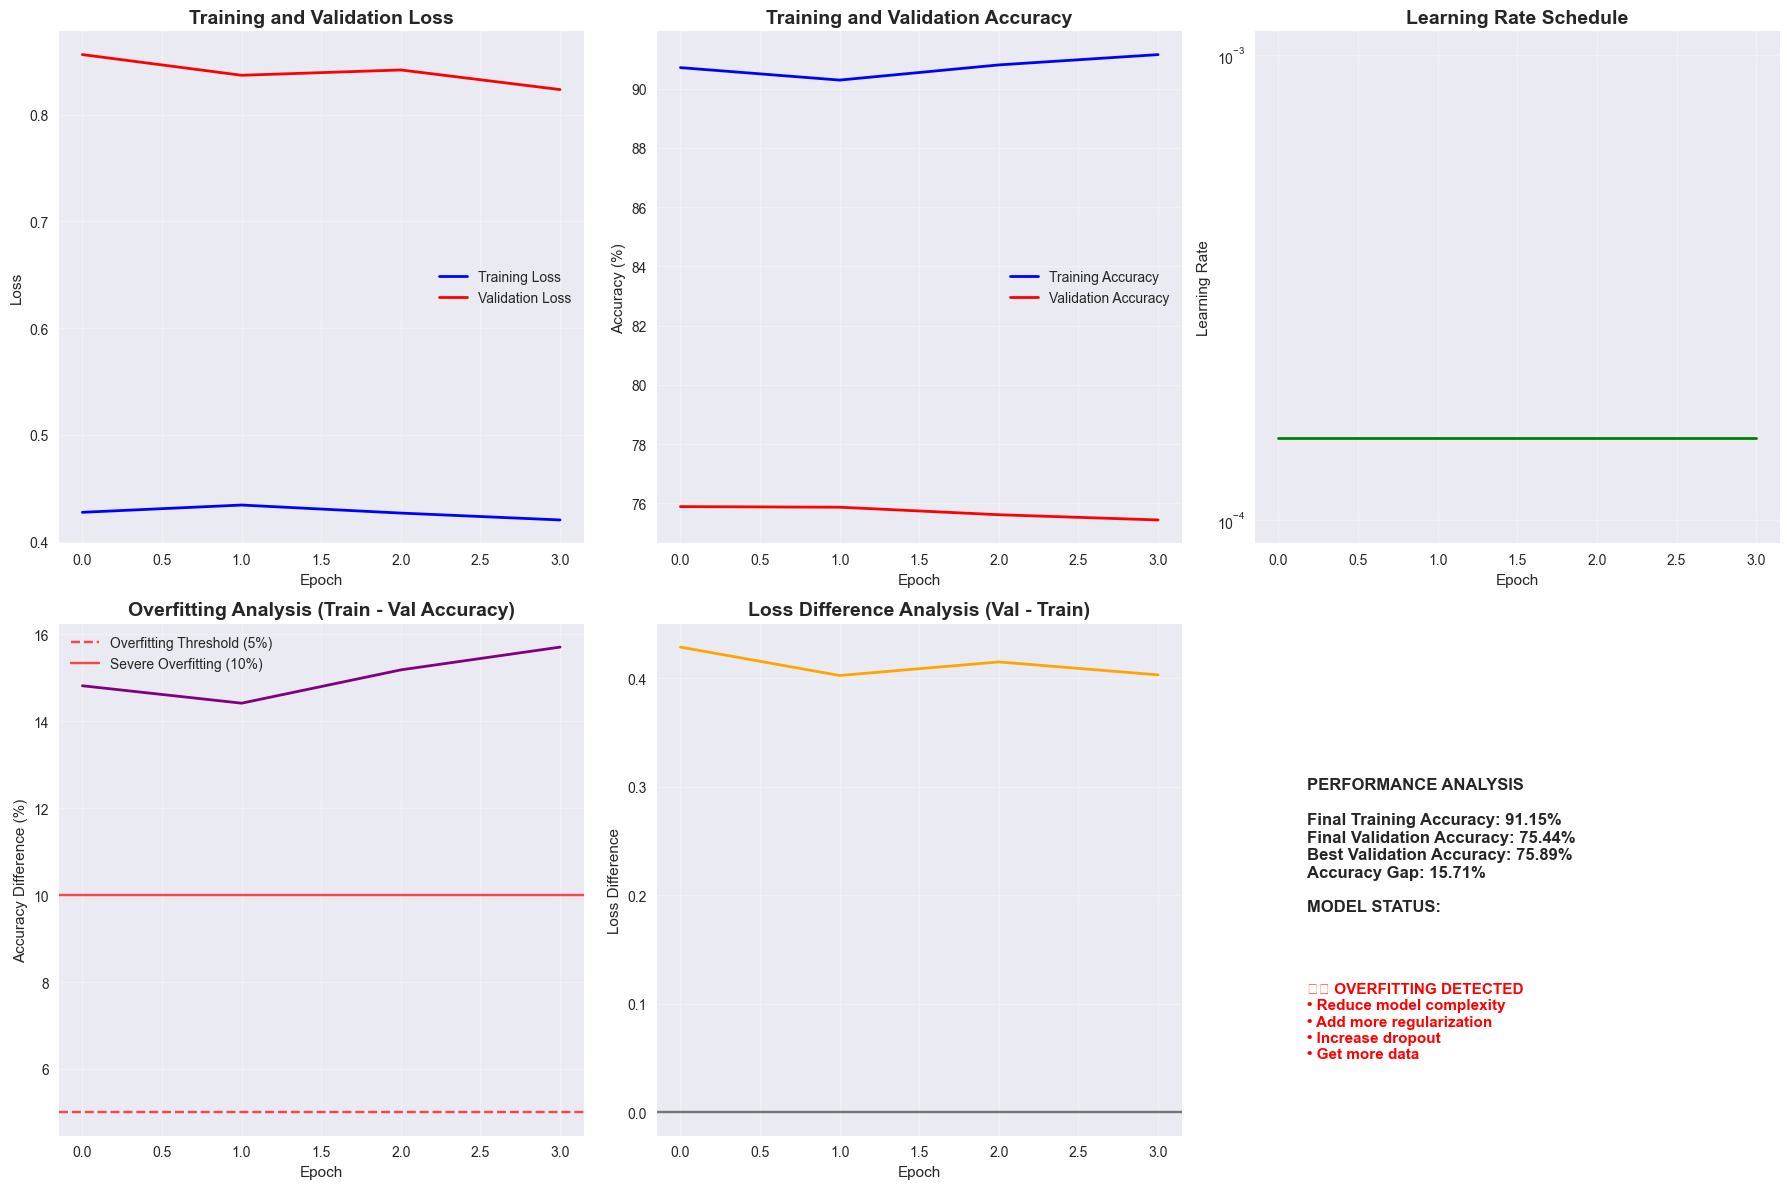

In [22]:
# Comprehensive visualization function
def plot_training_results(history):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Loss curves
    axes[0, 0].plot(history['train_losses'], label='Training Loss', color='blue', linewidth=2)
    axes[0, 0].plot(history['val_losses'], label='Validation Loss', color='red', linewidth=2)
    axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy curves
    axes[0, 1].plot(history['train_accuracies'], label='Training Accuracy', color='blue', linewidth=2)
    axes[0, 1].plot(history['val_accuracies'], label='Validation Accuracy', color='red', linewidth=2)
    axes[0, 1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Learning rate
    axes[0, 2].plot(history['learning_rates'], color='green', linewidth=2)
    axes[0, 2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Learning Rate')
    axes[0, 2].set_yscale('log')
    axes[0, 2].grid(True, alpha=0.3)
    
    # Overfitting analysis
    train_val_diff = np.array(history['train_accuracies']) - np.array(history['val_accuracies'])
    axes[1, 0].plot(train_val_diff, color='purple', linewidth=2)
    axes[1, 0].axhline(y=5, color='red', linestyle='--', alpha=0.7, label='Overfitting Threshold (5%)')
    axes[1, 0].axhline(y=10, color='red', linestyle='-', alpha=0.7, label='Severe Overfitting (10%)')
    axes[1, 0].set_title('Overfitting Analysis (Train - Val Accuracy)', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy Difference (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Loss difference analysis
    loss_diff = np.array(history['val_losses']) - np.array(history['train_losses'])
    axes[1, 1].plot(loss_diff, color='orange', linewidth=2)
    axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[1, 1].set_title('Loss Difference Analysis (Val - Train)', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss Difference')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Performance summary
    axes[1, 2].axis('off')
    
    # Analysis text
    final_train_acc = history['train_accuracies'][-1]
    final_val_acc = history['val_accuracies'][-1]
    best_val_acc = max(history['val_accuracies'])
    final_diff = final_train_acc - final_val_acc
    
    analysis_text = f"""PERFORMANCE ANALYSIS
    
Final Training Accuracy: {final_train_acc:.2f}%
Final Validation Accuracy: {final_val_acc:.2f}%
Best Validation Accuracy: {best_val_acc:.2f}%
Accuracy Gap: {final_diff:.2f}%

MODEL STATUS:
"""
    
    if final_diff > 10:
        status = "⚠️ OVERFITTING DETECTED\n• Reduce model complexity\n• Add more regularization\n• Increase dropout\n• Get more data"
        color = 'red'
    elif final_diff > 5:
        status = "⚡ MILD OVERFITTING\n• Monitor closely\n• Consider early stopping\n• Tune regularization"
        color = 'orange'
    elif final_val_acc < 60:
        status = "📈 UNDERFITTING\n• Increase model complexity\n• Reduce regularization\n• Train longer\n• Check data quality"
        color = 'blue'
    else:
        status = "✅ GOOD PERFORMANCE\n• Model is well-balanced\n• Consider fine-tuning\n• Ready for deployment"
        color = 'green'
    
    axes[1, 2].text(0.1, 0.7, analysis_text, fontsize=12, fontweight='bold', 
                   verticalalignment='top', transform=axes[1, 2].transAxes)
    axes[1, 2].text(0.1, 0.3, status, fontsize=11, color=color, fontweight='bold',
                   verticalalignment='top', transform=axes[1, 2].transAxes)
    
    plt.tight_layout()
    plt.savefig('../results/fine-tune/cnn_training_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot training results
plot_training_results(training_history)

In [23]:
# Detailed evaluation on test set
def evaluate_model():
    # Load best model
    checkpoint = torch.load(os.path.join(config.models_dir_fine_tune, config.model_name_fine_tune))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(config.device), target.to(config.device)
            output = model(data)
            probs = torch.softmax(output, dim=1)
            _, predicted = torch.max(output, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

# Get predictions
predictions, true_labels, probabilities = evaluate_model()

# Calculate metrics
accuracy = (predictions == true_labels).mean() * 100
f1 = f1_score(true_labels, predictions, average='weighted') * 100
precision = precision_score(true_labels, predictions, average='weighted') * 100
recall = recall_score(true_labels, predictions, average='weighted') * 100

print(f"\nFinal Model Performance:")
print(f"Accuracy: {accuracy:.2f}%")
print(f"F1-Score: {f1:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")


Final Model Performance:
Accuracy: 75.89%
F1-Score: 75.62%
Precision: 76.23%
Recall: 75.89%


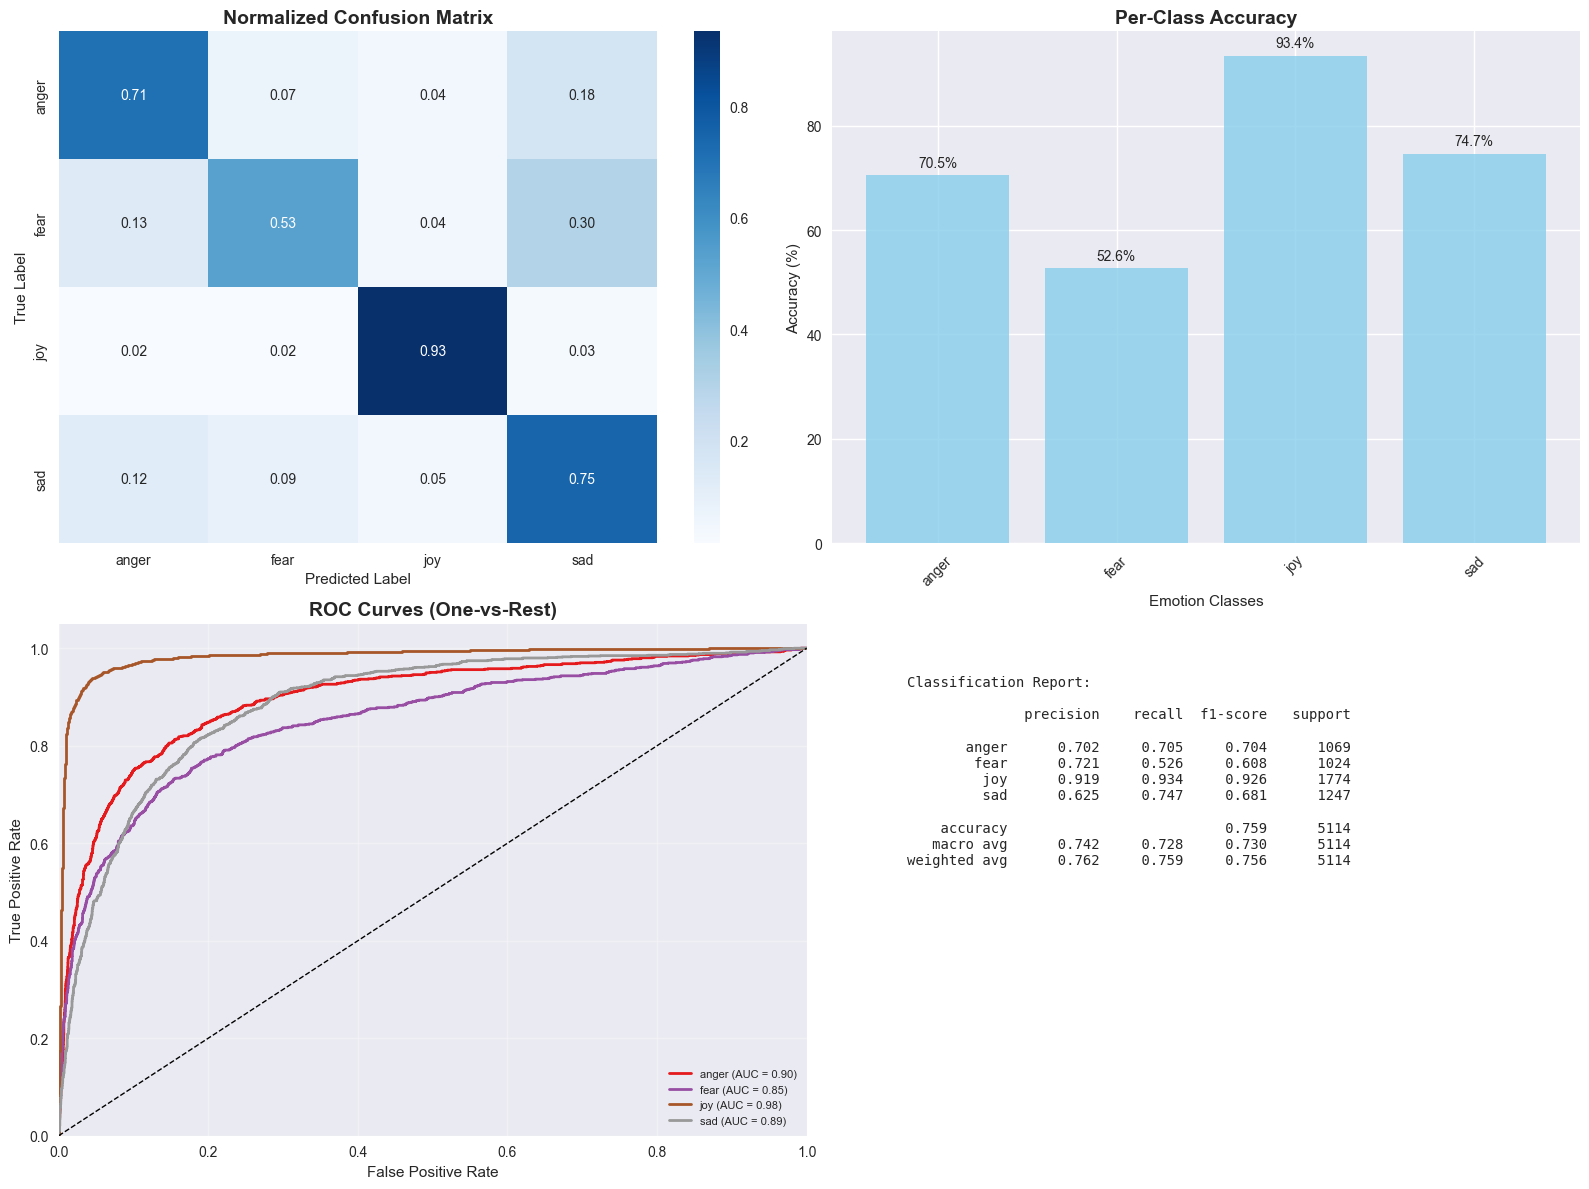

In [24]:
# Confusion Matrix and Classification Report
def plot_evaluation_metrics(y_true, y_pred, y_probs, class_names):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=axes[0, 0])
    axes[0, 0].set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Predicted Label')
    axes[0, 0].set_ylabel('True Label')
    
    # Per-class accuracy
    class_accuracies = cm.diagonal() / cm.sum(axis=1) * 100
    bars = axes[0, 1].bar(class_names, class_accuracies, color='skyblue', alpha=0.8)
    axes[0, 1].set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Emotion Classes')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, acc in zip(bars, class_accuracies):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                       f'{acc:.1f}%', ha='center', va='bottom')
    
    # ROC Curves (One-vs-Rest)
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
    
    colors = plt.cm.Set1(np.linspace(0, 1, len(class_names)))
    for i, (class_name, color) in enumerate(zip(class_names, colors)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        axes[1, 0].plot(fpr, tpr, color=color, linewidth=2,
                       label=f'{class_name} (AUC = {roc_auc:.2f})')
    
    axes[1, 0].plot([0, 1], [0, 1], 'k--', linewidth=1)
    axes[1, 0].set_xlim([0.0, 1.0])
    axes[1, 0].set_ylim([0.0, 1.05])
    axes[1, 0].set_xlabel('False Positive Rate')
    axes[1, 0].set_ylabel('True Positive Rate')
    axes[1, 0].set_title('ROC Curves (One-vs-Rest)', fontsize=14, fontweight='bold')
    axes[1, 0].legend(loc="lower right", fontsize=8)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Classification Report as text
    axes[1, 1].axis('off')
    report = classification_report(y_true, y_pred, target_names=class_names, digits=3)
    axes[1, 1].text(0.1, 0.9, 'Classification Report:\n\n' + report, 
                   fontsize=10, fontfamily='monospace',
                   verticalalignment='top', transform=axes[1, 1].transAxes)
    
    plt.tight_layout()
    plt.savefig('../results/cnn_evaluation_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot evaluation metrics
plot_evaluation_metrics(true_labels, predictions, probabilities, class_names)

In [ ]:
# =========================================================
# Inference + Folder Eval + Diagnostic Checklist (1 file)
# =========================================================
import os
from pathlib import Path
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset
from PIL import Image, ImageFilter
import pandas as pd
import cv2

# -----------------------------
# 0) KONFIGURASI
# -----------------------------
CHECKPOINT_PATH = r"E:\Folder Kuliah\Semester 7\CCI\Github Repository\emotion-detection\models\fine-tune\cnn_emotion_model_v6-2.pth"
PATH_GAMBAR    = r"E:\Folder Kuliah\Semester 7\CCI\Github Repository\emotion-detection\images\test\anger_WIN_20251009_00_23_48_Pro.jpg"
FOLDER_PATH    = r"E:\Folder Kuliah\Semester 7\CCI\Github Repository\emotion-detection\images\test"
OUT_DIR        = r"E:\Folder Kuliah\Semester 7\CCI\Github Repository\emotion-detection\results\fine-tune"

# Jika di notebook kamu sudah ada `config`, variabel di bawah otomatis baca dari situ.
IMG_SIZE = getattr(globals().get('config', object()), 'img_size', 224)
MEAN     = getattr(globals().get('config', object()), 'mean', [0.485, 0.456, 0.406])
STD      = getattr(globals().get('config', object()), 'std',  [0.229, 0.224, 0.225])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -----------------------------
# 1) MODEL (identik dengan training)
# -----------------------------
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.backbone.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.backbone(x)

# -----------------------------
# 2) LOAD CHECKPOINT + TRANSFORM
# -----------------------------
def load_checkpoint(path):
    ckpt = torch.load(path, map_location=device)
    # dukung beberapa kemungkinan kunci:
    state_keys = ['model_state_dict', 'state_dict', 'ema_state_dict', 'model']
    state_dict = None
    for k in state_keys:
        if k in ckpt:
            obj = ckpt[k]
            state_dict = obj.state_dict() if hasattr(obj, 'state_dict') else obj
            break
    if state_dict is None and all(isinstance(v, torch.Tensor) for v in ckpt.values()):
        state_dict = ckpt  # pure state_dict

    class_names = ckpt.get('class_names', ['anger', 'fear', 'joy', 'sad'])
    model = EmotionCNN(num_classes=len(class_names)).to(device)
    if state_dict is None:
        raise RuntimeError("Tidak menemukan state_dict dalam checkpoint. Pastikan kuncinya 'model_state_dict' atau serupa.")
    model.load_state_dict(state_dict, strict=True)
    model.eval()
    return model, class_names

# Transform VAL **persis** seperti training: Resize -> ToTensor -> Normalize (tanpa center-crop)
val_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

# Varian lain untuk diagnosa
val_tf_center = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.14)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])
val_tf_no_norm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

def detect_and_crop_face(path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if len(faces) == 0:
        return Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    (x, y, w, h) = faces[0]
    margin_x = int(0.15 * w)          # sebelumnya 0.2 * w (horisontal bisa lebih kecil)
    margin_top = int(0.10 * h)        # atas sedikit saja
    margin_bot = int(0.35 * h)        # ✅ bawah diperbesar (mulut/dagu masuk)

    x1 = max(0, x - margin_x)
    y1 = max(0, y - margin_top)
    x2 = min(img.shape[1], x + w + margin_x)
    y2 = min(img.shape[0], y + h + margin_bot)
    face_crop = img[y1:y2, x1:x2]
    
    return Image.fromarray(cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB))

# -----------------------------
# 3) PREDIKSI SATU GAMBAR
# -----------------------------
def preprocess_image(path):
    img = detect_and_crop_face(path)          # PIL RGB

    # === CLAHE: samakan kontras dgn dataset ===
    g = np.array(img.convert("L"))            # ke grayscale (array 2D)
    clahe = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(8,8))
    g = clahe.apply(g)                        # equalize lokal
    img = Image.fromarray(g).convert("RGB")   # balik ke 3-channel RGB

    # return val_tf(img).unsqueeze(0).to(device)
    return val_tf(img).to(device) 


@torch.inference_mode()
def predict_emotion(model, x_tensor, class_names):
    logits = model(x_tensor)
    probs = F.softmax(logits, dim=1)[0]
    conf, idx = probs.max(dim=0)
    return {
        'emotion': class_names[idx.item()],
        'confidence': float(conf.item()),
        'all_probs': {class_names[i]: float(probs[i].item()) for i in range(len(class_names))},
        'entropy': float(-torch.sum(probs * torch.log(probs + 1e-12)).item())
    }

# TTA ringan (flip horizontal + resize-center)
@torch.inference_mode()
def predict_tta(model, img_pil, class_names):
    tfs = [
        val_tf,
        lambda im: val_tf(im.transpose(Image.FLIP_LEFT_RIGHT))
    ]
    # acc = 0
    # for tf in tfs:
    #     x = (tf(img_pil) if callable(tf) else tf(im)).unsqueeze(0).to(device) if False else None
    # implement properly
    probs_sum = None
    for tf in tfs:
        x = (tf(img_pil) if not callable(tf) else tf(img_pil)).unsqueeze(0).to(device)
        p = F.softmax(model(x), dim=1)
        probs_sum = p if probs_sum is None else probs_sum + p
    probs = (probs_sum / len(tfs))[0]
    conf, idx = probs.max(dim=0)
    return class_names[idx.item()], float(conf.item())

# -----------------------------
# 4) FOLDER: EVALUASI / PREDIKSI
# -----------------------------
class FlatFolder(Dataset):
    exts = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")
    def __init__(self, root, tf):
        self.paths = [str(p) for p in Path(root).glob("*") if p.suffix.lower() in self.exts]
        self.tf = tf
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        p = self.paths[i]
        try:
            img = Image.open(p).convert("RGB")
            return self.tf(img), p
        except Exception as e:
            print(f"⚠️ Skip file error: {p} ({e})")
            dummy = torch.zeros(3, IMG_SIZE, IMG_SIZE)
            return dummy, p

def is_imagefolder_like(root):
    rootp = Path(root)
    subs = [d for d in rootp.iterdir() if d.is_dir()]
    if len(subs) < 2: return False
    exts = FlatFolder.exts
    return any(any(p.suffix.lower() in exts for p in d.glob("*")) for d in subs)
            
@torch.inference_mode()
def run_folder(model, class_names, folder_path, result_path, preprocess_fn, batch_size=32, save_csv=True):
    folder_path = Path(folder_path)
    result_path = Path(result_path)
    result_path.mkdir(parents=True, exist_ok=True)
    ts = pd.Timestamp.now().strftime('%Y%m%d-%H%M%S')

    files = [p for p in folder_path.iterdir() if p.suffix.lower() in ['.jpg', '.jpeg', '.png']]
    results = []

    for i in tqdm(range(0, len(files), batch_size)):
        batch_files = files[i:i+batch_size]
        batch_imgs, batch_names = [], []
        for f in batch_files:
            try:
                x = preprocess_fn(str(f))
                if x.ndim == 4 and x.shape[0] == 1:      # [1,3,H,W]
                    x = x.squeeze(0)
                batch_imgs.append(x)                      # [3,H,W]
                batch_names.append(f.name)
            except Exception as e:
                print(f"⚠️ Error pada {f.name}: {e}")
        
        if not batch_imgs:
            continue

        batch_tensor = torch.stack(batch_imgs).to(device)
        probs = F.softmax(model(batch_tensor), dim=1)
        conf, pred = probs.max(dim=1)
        for fname, pi, cf in zip(batch_names, pred.cpu().tolist(), conf.cpu().tolist()):
            results.append({
                'file': fname,
                'emotion': class_names[pi] if class_names else str(pi),
                'confidence': float(cf)
            })

    # Distribusi prediksi
    if results:
        pred_labels = [r['emotion'] for r in results]
        distrib = {lbl: pred_labels.count(lbl) for lbl in set(pred_labels)}
        print("Distribusi prediksi:", distrib)
    else:
        print("Tidak ada gambar valid untuk diproses.")
        distrib = {}

    # Simpan ke CSV
    if save_csv and results:
        df_results = pd.DataFrame(results)
        csv_path = result_path / f"predictions_{ts}.csv"
        df_results.to_csv(csv_path, index=False)
        print(f"✅ Prediksi selesai. Hasil disimpan ke: {csv_path}")
    
    return {
        "num_samples": len(results),
        "counts": distrib
    }

# -----------------------------
# 5) CHECKLIST DIAGNOSTIK
# -----------------------------
def diagnostic_checklist(model, class_names, image_path):
    print("\n=== DIAGNOSTIC CHECKLIST ===")
    img = Image.open(image_path).convert("RGB")

    # a) pipeline VAL (seharusnya benar)
    x_val = val_tf(img).unsqueeze(0).to(device)
    r_val = predict_emotion(model, x_val, class_names)
    print(f"[VAL]       -> {r_val['emotion']:<6}  conf={r_val['confidence']:.3f}  entropy={r_val['entropy']:.3f}")

    # b) center-crop variant (kalau training tidak pakai ini, beda hasil = tanda mismatch)
    x_cc  = val_tf_center(img).unsqueeze(0).to(device)
    r_cc  = predict_emotion(model, x_cc, class_names)
    print(f"[CenterCrop]-> {r_cc['emotion']:<6}  conf={r_cc['confidence']:.3f}  entropy={r_cc['entropy']:.3f}")

    # c) tanpa normalisasi (jika hasilnya berubah drastis, normalisasi saat inference sudah benar)
    x_nn  = val_tf_no_norm(img).unsqueeze(0).to(device)
    with torch.inference_mode():
        logits = model(x_nn)
        probs = F.softmax(logits, dim=1)[0]
        conf, idx = probs.max(dim=0)
        entropy = float(-torch.sum(probs * torch.log(probs + 1e-12)).item())
    print(f"[No-Norm]   -> {class_names[idx.item()]:<6}  conf={float(conf.item()):.3f}  entropy={entropy:.3f}")

    # d) flip horizontal (robustness pose)
    r_flip = predict_emotion(model, val_tf(img.transpose(Image.FLIP_LEFT_RIGHT)).unsqueeze(0).to(device), class_names)
    print(f"[Flip]      -> {r_flip['emotion']:<6}  conf={r_flip['confidence']:.3f}")

    # e) blur ringan (robustness kualitas)
    r_blur = predict_emotion(model, val_tf(img.filter(ImageFilter.GaussianBlur(radius=1))).unsqueeze(0).to(device), class_names)
    print(f"[Blur]      -> {r_blur['emotion']:<6}  conf={r_blur['confidence']:.3f}")

    # f) TTA (average)
    lbl_tta, conf_tta = predict_tta(model, img, class_names)
    print(f"[TTA avg]   -> {lbl_tta:<6}  conf={conf_tta:.3f}")

    # g) probabilitas lengkap (cek bias ke satu kelas)
    print("[Probs VAL] :", {k: round(v,3) for k,v in r_val['all_probs'].items()})

# -----------------------------
# 6) RUN
# -----------------------------
if __name__ == "__main__":
    os.makedirs(OUT_DIR, exist_ok=True)
    model, class_names = load_checkpoint(CHECKPOINT_PATH)

    print("== Single image prediction ==")
    x = preprocess_image(PATH_GAMBAR).unsqueeze(0).to(device)
    res = predict_emotion(model, x, class_names)
    print(res)

    # Diagnostic checklist
    diagnostic_checklist(model, class_names, PATH_GAMBAR)

    print("\n== Folder inference/evaluation ==")
    run_folder(model, class_names, FOLDER_PATH, OUT_DIR, preprocess_image, save_csv=True)


== Single image prediction ==
{'emotion': 'anger', 'confidence': 0.9112626314163208, 'all_probs': {'anger': 0.9112626314163208, 'fear': 0.027828862890601158, 'joy': 0.02545945532619953, 'sad': 0.0354490764439106}, 'entropy': 0.3961934447288513}

=== DIAGNOSTIC CHECKLIST ===
[VAL]       -> anger   conf=0.831  entropy=0.640
[CenterCrop]-> sad     conf=0.370  entropy=1.283
[No-Norm]   -> anger   conf=0.335  entropy=1.345
[Flip]      -> anger   conf=0.610
[Blur]      -> anger   conf=0.824
[TTA avg]   -> anger   conf=0.720
[Probs VAL] : {'anger': 0.831, 'fear': 0.062, 'joy': 0.046, 'sad': 0.061}

== Folder inference/evaluation ==


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

Distribusi prediksi: {'anger': 1, 'sad': 2, 'joy': 1}
✅ Prediksi selesai. Hasil disimpan ke: E:\Folder Kuliah\Semester 7\CCI\Github Repository\emotion-detection\results\fine-tune\predictions_20251011-092837.csv
